### Часть 2. Кластеризация рейсов для определения контрольной группы

Если в продуктовых тестах, осуществляемых на сайте, четко определены тестовая и контрольная группы, то технология проведения ценовых тестов (изменение цен на дополнительные услуги) не предусматривает выделения контрольной группы. В связи с этим возникает проблема определения эффективности теста.

Как вариант решения проблемы - кластеризация рейсов с целью выявления похожих рейсов по ряду параметров: пенетрация услуги "Выбор места", удельная выручка на пассажира, средний чек, расстояние. 

При этом важно понимать, что маршрутная сеть разнообразна и часть рейсов будут уникальны и не войдут ни в один кластер (выбросы), поэтому предлагается для рейсов в одном кластере применять межрейсовое сравнение, а для специфичных рейсов при проведении тестов сравнивать результаты до и после тестов.

![](https://pro.arcgis.com/ru/pro-app/latest/tool-reference/spatial-statistics/GUID-A06A412D-2F4F-4D35-8FFF-1F4B3B3A8F16-web.png)

**Оценка качества** кластеризации будет проходить с использованием **коэффициент силуэта**, который показывает, насколько объект похож на свой кластер по сравнению с другими кластерами:
$$S = {{b-a}\over\max(a,b)}$$

a — среднее расстояние от данного объекта до объектов из того же кластера;

b — среднее расстояние от данного объекта до объектов из ближайшего кластера.

Значение коэффициента находится в диапазоне от **-1 до +1**, где высокое значение указывает, что объект хорошо согласуется с кластером, которому он принадлежит, и плохо согласуется с «чужими» кластерами. Если у подавляющего большинства объектов этот коэффициент высокий, то можно считать кластеризацию достаточно качественной. Если же у большого числа объектов низкий или отрицательный коэффициент силуэта, то, возможно, кластеров слишком много, слишком мало или просто данные плохо поддаются разделению на кластеры.

### 1. Импортирование библиотек

In [1]:
# библиотеки для работы с данными
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# библиотеки для статистического анализа
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# библиотеки для визуализации
import altair as alt
# отключение ограничения в 5000 строк для alt
alt.data_transformers.disable_max_rows()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# опции для вывода данных в нужном количестве и формате
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.5f}'.format)

# импортируем библиотеку для работы с алгоритмом K-means
from sklearn.cluster import KMeans

# импортируем библиотеку для работы с ЕМ - алгоритмом
from sklearn.mixture import GaussianMixture

# импортируем библиотеку для работы с агломеративной кластеризацией
from sklearn.cluster import AgglomerativeClustering

# импортируем библиотеки для работы с агломеративной кластеризацией и построением дендограммы
from scipy.cluster.hierarchy import dendrogram, linkage

# импортируем библиотеку для работы с алгоритмом DBSCAN
from sklearn.cluster import DBSCAN

# библиотеки для стандартизации и нормализации данных
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from catboost import CatBoostRegressor
import warnings
from sklearn.neighbors import kneighbors_graph

### 2. Применяемые функции

In [2]:
def count_elem_in_cluster(x, y, data, numb):
    
    """Функция используется для подсчета количества элементов в кластере"""
    
    cluster_count = pd.DataFrame(data.pivot_table(values = [x], index = [y], 
                                            aggfunc = 'count')).reset_index()
    cluster_count.columns = [['Номер кластера','Количество элементов']]
    cluster_count.iloc[:,1]
    
    plt.figure(figsize=(10,5))
    plt.bar(numb, list(cluster_count.iloc[:,1]))
    plt.title('Количество элементов, относящихся к каждому кластеру', fontsize=12, color='black')
    plt.xlabel('Количество кластеров', fontsize=12, color='black')
    plt.ylabel('Количество элементов', fontsize=12, color='black')
    plt.grid(True)
    plt.show()
    
    
def dif_cluster(x):
    
    """Функция используется для вывода средних метрик по каждому кластеру"""
    
    cluster = pd.DataFrame(df.pivot_table(values = ['Пенетрация_услуги','Расстояние','Средний_чек_услуги',
                                                'Удельная_выручка_на_пассажира'], index = [x], 
                                      aggfunc = 'mean')).reset_index()
    cluster.columns = [["Номер кластера","Пенетрация","Расстояние, км.","Средний чек, руб.","Уд. выручка на пас."]]
    return cluster

### 3. Обеспечение воспроизводимости экспериментов

In [3]:
# фиксация random_seed для воспроивзодимости экспериментов
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### 4. Знакомство с данными

In [4]:
df=pd.read_excel(r'C:\Users\1201065\Desktop\Дипломный проект\Данные для модели.xlsx')

In [5]:
df.head(3)

,Маршрут,Пенетрация_услуги,Удельная_выручка_на_пассажира,Тип_ВС,Средний_чек_услуги,Количество_проданных_сегментов,ВВЛ/МВЛ,Направленность,Налет,Тип_маршрута,Расстояние
0,IKT-VKO,0.40268,191.33119,Boeing Московский,487.57926,6337,ВВЛ,Московские,5.46666,Московские,4413.00000
1,AAQ-VKO,0.37797,163.35751,Boeing Московский,421.38962,84801,ВВЛ,Московские,2.08626,Московские,1390.68746
2,AER-TJM,0.36009,172.33264,Boeing Региональный,480.23171,9988,ВВЛ,Региональные,3.44479,Региональные,2548.65625


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 11 columns):
Маршрут                           160 non-null object
Пенетрация_услуги                 160 non-null float64
Удельная_выручка_на_пассажира     160 non-null float64
Тип_ВС                            160 non-null object
Средний_чек_услуги                160 non-null float64
Количество_проданных_сегментов    160 non-null int64
ВВЛ/МВЛ                           160 non-null object
Направленность                    160 non-null object
Налет                             160 non-null float64
Тип_маршрута                      160 non-null object
Расстояние                        160 non-null float64
dtypes: float64(5), int64(1), object(5)
memory usage: 13.9+ KB


Работа будет проведена над dataset, содержащим 160 строк, 11 колонок и следующие поля:
* **маршрут** - категориальная переменная, содержит информацию о пункте прилета и вылета;
* **пенетрация_услуги** - число, содержит информацию о том, сколько услуг "Выбор места" приходится на пассажиров;
* **удельная_выручка_на_пассажира** - число, удельная выручка по услуге;
* **тип_ВС** - категориальная переменная, тип воздушного судна;
* **средний_чек_услуги** - число;
* **количество_проданных_сегментов** - число;
* **ВВЛ/МВЛ** - категориальная переменная, внутренние и международные перевозки;
* **направленность** - категориальная переменная;
* **налет** -  число;
* **тип_маршрута** - категориальная переменная;
* **расстояние** - число.

In [7]:
df.describe()

,Пенетрация_услуги,Удельная_выручка_на_пассажира,Средний_чек_услуги,Количество_проданных_сегментов,Налет,Расстояние
count,160.00000,160.00000,160.00000,160.00000,160.00000,160.00000
mean,0.19071,84.55933,431.21865,10082.80625,2.49464,1528.64077
std,0.08127,45.29248,121.42053,16788.50766,1.20772,1076.52374
min,0.01187,3.59033,277.11111,20.00000,0.63889,217.44071
25%,0.13382,49.98401,328.62849,2100.50000,1.56335,648.11237
50%,0.18807,80.80268,432.77198,3667.50000,2.27387,1254.74650
75%,0.24953,115.18452,492.76478,9788.75000,3.16583,2211.31510
max,0.40268,259.27917,1085.06556,84801.00000,8.68444,6506.46471


In [8]:
# категориальные переменные в число
for colum in ['Тип_ВС','ВВЛ/МВЛ','Направленность','Тип_маршрута']:
    df[colum] = df[colum].astype('category').cat.codes

In [9]:
# возьмем только числовые признаки для анализа
X=df[['Пенетрация_услуги','Расстояние','Средний_чек_услуги','Удельная_выручка_на_пассажира']]

In [10]:
# проведем стандартизацию признаков
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(X) 

In [11]:
# нормализируем признаки
X = normalize(scaled_df) 
  
# конвертируем матрицу в df и извлекаем значения
X = pd.DataFrame(X).values

In [12]:
X

array([[ 0.58682308,  0.60283381,  0.10443725,  0.53039885],
       [ 0.79697001, -0.04432277, -0.02799865,  0.60173945],
       [ 0.68863581,  0.3130621 ,  0.13337272,  0.64030037],
       [ 0.63995428,  0.33865699,  0.20276242,  0.65928549],
       [ 0.75881671, -0.02126505,  0.08410738,  0.64550053],
       [ 0.77092138,  0.00227841,  0.06798013,  0.63328803],
       [ 0.66698196,  0.37009306,  0.15582569,  0.62760222],
       [ 0.85774342, -0.05382455, -0.4410869 ,  0.25849852],
       [ 0.52485151,  0.68221124,  0.11972017,  0.49475832],
       [ 0.72472095,  0.40834342,  0.03310541,  0.55402097],
       [ 0.56678389,  0.56421716,  0.20024667,  0.56596492],
       [ 0.62636874,  0.43063364,  0.20309937,  0.61722566],
       [ 0.55416918,  0.53877985,  0.23044946,  0.59119019],
       [ 0.7814394 , -0.36035026, -0.47296816,  0.18921226],
       [ 0.58287751,  0.5956853 ,  0.14318353,  0.53377083],
       [ 0.67398446,  0.64176204, -0.17985645,  0.31865042],
       [ 0.50388541,  0.

### 5. Применение алгоритмов кластеризации (обучение без учителя)

### 5.1. k-means

**k-means** является одним из самых популярных и простых алгоритмов кластеризации. В ходе этого алгоритма все элементы пространства разбиваются на заранее известное (заданное) количество кластеров. Суть алгоритма состоит в том, что он пытается оптимизировать расстояние всех точек кластера от центра этого кластера. То есть он формирует кластеры так, чтобы внутри каждого сумма квадратов расстояний от точек до центра кластера была как можно меньше.

**Этапы работы алгоритма:**
* выбрать количество кластеров, которое нам кажется оптимальным для наших данных;
* выбрать случайным образом в пространство наших данных центроиды;
* для каждой точки набора данных посчитать, к какому центроиду она ближе;
* переместить каждый центроид в центр выборки, которую мы отнесли к этому центроиду. Каждый центроид на каждой итерации — вектор, элементы которого представляют собой средние значения признаков, вычисленные по всем записям кластера;
* повторять шаги 3-4 фиксированное число раз или до тех пор, пока центроиды не сойдутся.

Для начала необходимо определить **оптимальное количество** групп (кластеров) K. Для этого воспользуемся двумя методами:
1. **"метод локтя"**, который подразумевает многократное циклическое исполнение алгоритма с увеличением количества выбираемых кластеров, а также последующим откладыванием на графике балла кластеризации, вычисленного как функция от количества кластеров.  Балл, как правило, является мерой входных данных по целевой функции k-средних, то есть некой формой отношения внутрикластерного расстояния к межкластерному расстоянию.

Определим количество кластеров первым способом.

In [13]:
# в цикле будем увеличивать кол-во кластеров и обучать модель, добавляя в список wcss inertia

wcss = []
for i in range(1, 11):
    # кол-во кластеров перебираем от 1 до 10, метод инициализации k-means++
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    # обучаем модель
    kmeans.fit(X)
    # inertia это сумма квадратов расстояний от образцов до ближайшего центра кластера
    wcss.append(kmeans.inertia_)

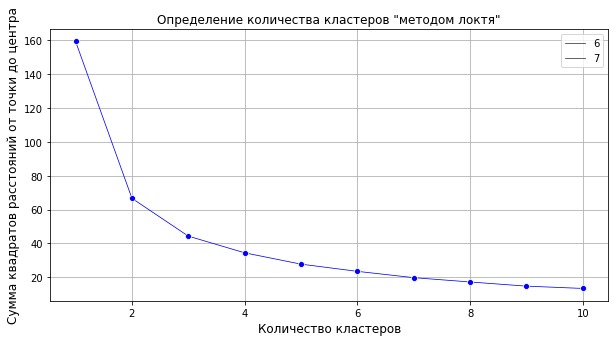

In [14]:
# выведем график

plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), wcss, marker='o',color='blue',size=7)
plt.title('Определение количества кластеров "методом локтя"', fontsize=12, color='black')
plt.xlabel('Количество кластеров', fontsize=12, color='black')
plt.ylabel('Сумма квадратов расстояний от точки до центра', fontsize=12, color='black')
plt.grid(True)
plt.show()

"Метод локтя" указывает на то, что оптимальное количество кластеров **4 или 5 шт.**

2. **коэффициент силуэта**.

Определим количество кластеров вторым способом:

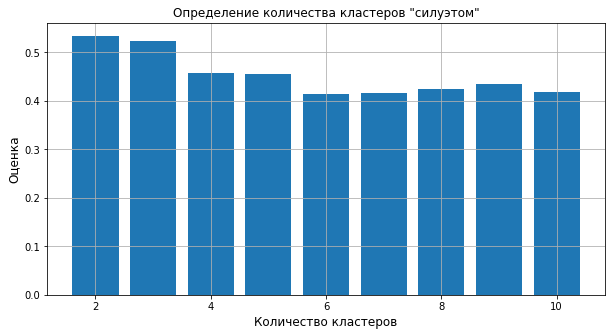

In [15]:
# данные по оценке
silhouette_scores = [] 

for n_cluster in range(2, 11):
    silhouette_scores.append(silhouette_score(X, KMeans(n_clusters = n_cluster).fit_predict(X))) 
    
plt.figure(figsize=(10,5))
k = [2,3,4,5,6,7,8,9,10]
plt.bar(k, silhouette_scores)
plt.title('Определение количества кластеров "силуэтом"', fontsize=12, color='black')
plt.xlabel('Количество кластеров', fontsize=12, color='black')
plt.ylabel('Оценка', fontsize=12, color='black')
plt.grid(True)
plt.show()

Значение коэффициента указывает на то, что оптимальное количество кластеров **2 шт.**

In [16]:
# обучим модель
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

In [17]:
# добавим номер кластера отдельной колонкой в df
df['Кластер K-means'] = kmeans.labels_
df.head(3)

,Маршрут,Пенетрация_услуги,Удельная_выручка_на_пассажира,Тип_ВС,Средний_чек_услуги,Количество_проданных_сегментов,ВВЛ/МВЛ,Направленность,Налет,Тип_маршрута,Расстояние,Кластер K-means
0,IKT-VKO,0.40268,191.33119,2,487.57926,6337,0,1,5.46666,0,4413.00000,0
1,AAQ-VKO,0.37797,163.35751,2,421.38962,84801,0,1,2.08626,0,1390.68746,0
2,AER-TJM,0.36009,172.33264,3,480.23171,9988,0,2,3.44479,1,2548.65625,0


In [18]:
# список номеров кластера
df['Кластер K-means'].unique()

array([0, 1], dtype=int64)

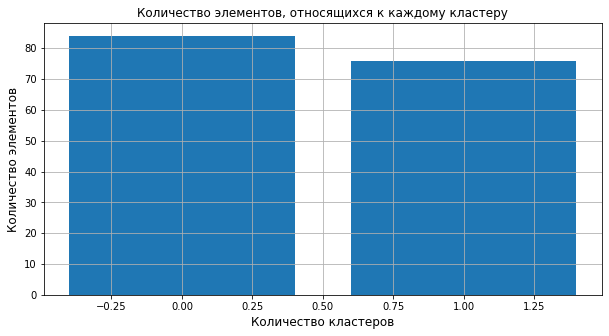

In [19]:
# посмотрим на кол-во элементов в каждом кластере
count_elem_in_cluster('Маршрут','Кластер K-means', df, list(df['Кластер K-means'].unique()))

In [20]:
# выведем отличия между кластерами
dif_cluster('Кластер K-means')

,Номер кластера,Пенетрация,"Расстояние, км.","Средний чек, руб.",Уд. выручка на пас.
0,0,0.23402,2238.61699,515.31880,116.84244
1,1,0.14283,743.93022,338.26585,48.87801


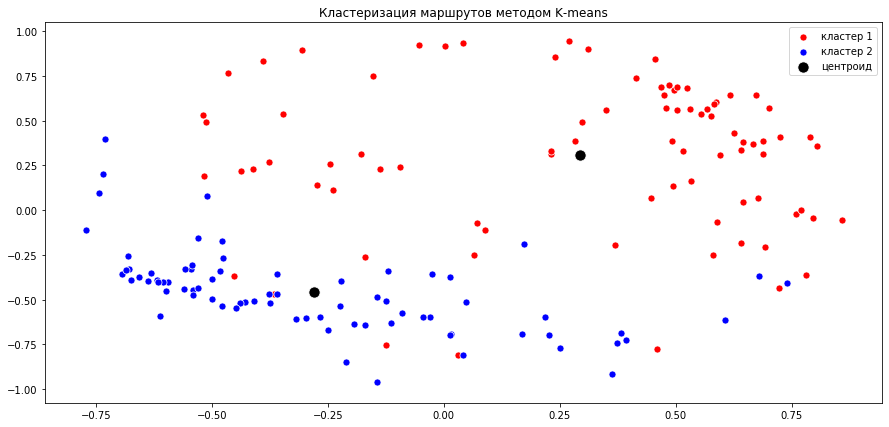

In [21]:
# строим визуализацию

plt.figure(figsize=(15,7))
sns.scatterplot(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], color = 'red', label = 'кластер 1',s=50)
sns.scatterplot(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], color = 'blue', label = 'кластер 2',s=50)
# выведем центры
sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'black', label = 'центроид',
                s=500, marker='.')
plt.title('Кластеризация маршрутов методом K-means', fontsize=12, color='black')
plt.legend()
plt.show()

**Вывод:** используя метод k-means имеющиеся данные можно разделить на 2 кластера с коэффициентов силуэта, равным 0,53.

### 5.2.  Aлгоритм максимизации ожидания (EM)

**Схема действий EM-алгоритма:**

* выбрать количество кластеров, которое нам кажется оптимальным для наших данных;
* выбрать случайным образом в пространство наших данных параметры распределений;
* для каждой точки нашего набора данных посчитать вероятность принадлежности к каждому кластеру;
* обновить параметры распределений таким образом, чтобы максимизировать вероятность принадлежности точек, отнесённых к кластеру;
* повторять шаги 3-4 фиксированное число раз, либо до тех пор пока центроиды не сойдутся.

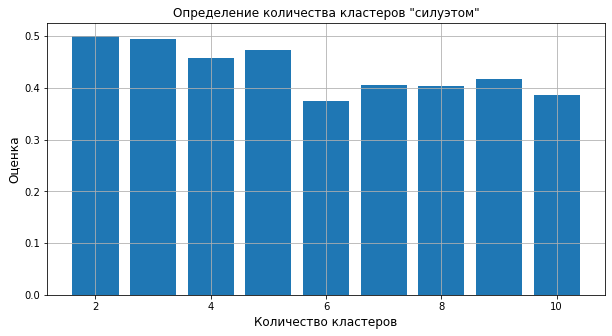

In [22]:
silhouette_score_em = []

for n_cluster in range(2,11):
    em_gm = GaussianMixture(n_components=n_cluster, # количество кластеров
                        max_iter=100, # количество интераций
                        init_params='kmeans' # 'kmeans’, ‘random’
                       )
    y_pred_em = em_gm.fit_predict(X)
    silhouette_score_em.append(silhouette_score(X=X, labels=y_pred_em, metric='euclidean'))

plt.figure(figsize=(10,5))
k = [2,3,4,5,6,7,8,9,10]
plt.bar(k, silhouette_score_em)
plt.title('Определение количества кластеров "силуэтом"', fontsize=12, color='black')
plt.xlabel('Количество кластеров', fontsize=12, color='black')
plt.ylabel('Оценка', fontsize=12, color='black')
plt.grid(True)
plt.show()

Согласно коэффициенту силуэта оптимальное количество кластеров - **2 шт. (0,5)**. Однако попробуем разделить данные на 4 кластера с коэффициентом силуэта 0,47.

In [23]:
# создадим объект
em_gm = GaussianMixture(n_components=4, # количество кластеров
                        max_iter=100, # количество интераций
                        init_params='kmeans' # 'kmeans’, ‘random’
                       )

In [24]:
# обучим модель
y_pred_em = em_gm.fit_predict(X)
y_pred_em

array([0, 3, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3,
       0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3,
       0, 1, 0, 3, 2, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 3, 0, 1,
       2, 0, 3, 0, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 2, 0, 2, 2, 2, 1,
       1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1,
       2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2,
       2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1], dtype=int64)

In [25]:
df['Кластер EM'] = y_pred_em
df.head(3)

,Маршрут,Пенетрация_услуги,Удельная_выручка_на_пассажира,Тип_ВС,Средний_чек_услуги,Количество_проданных_сегментов,ВВЛ/МВЛ,Направленность,Налет,Тип_маршрута,Расстояние,Кластер K-means,Кластер EM
0,IKT-VKO,0.40268,191.33119,2,487.57926,6337,0,1,5.46666,0,4413.00000,0,0
1,AAQ-VKO,0.37797,163.35751,2,421.38962,84801,0,1,2.08626,0,1390.68746,0,3
2,AER-TJM,0.36009,172.33264,3,480.23171,9988,0,2,3.44479,1,2548.65625,0,0


In [26]:
# список номеров кластера
df['Кластер EM'].unique()

array([0, 3, 1, 2], dtype=int64)

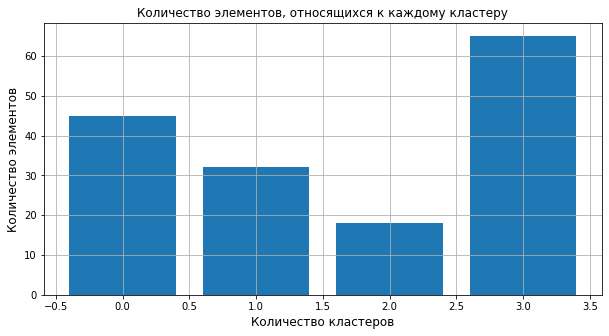

In [27]:
# посмотрим на кол-во элементов в каждом кластере
count_elem_in_cluster('Маршрут','Кластер EM', df, list(df['Кластер EM'].unique()))

In [28]:
# выведем отличия между кластерами
dif_cluster('Кластер EM')

,Номер кластера,Пенетрация,"Расстояние, км.","Средний чек, руб.",Уд. выручка на пас.
0,0,0.26649,2688.76858,484.96035,128.57604
1,1,0.13612,674.01117,324.02225,44.64932
2,2,0.14844,1807.72406,573.44392,85.19609
3,3,0.27350,1218.33567,431.11758,117.50506


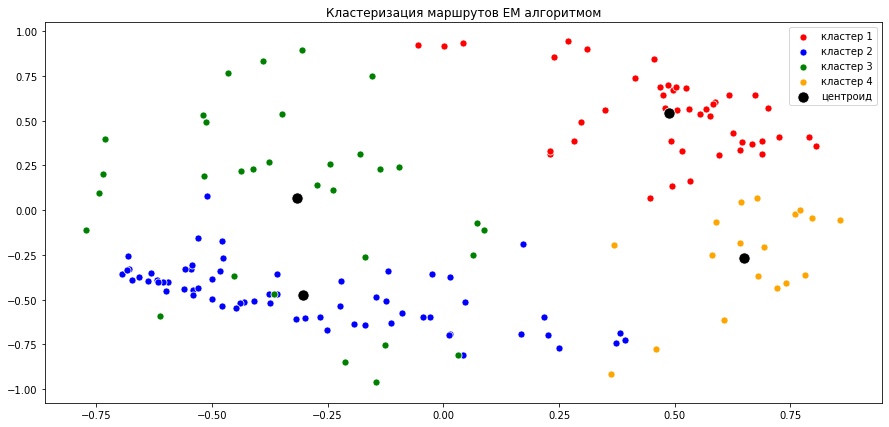

In [29]:
# строим визуализацию

plt.figure(figsize=(15,7))
sns.scatterplot(X[y_pred_em == 0, 0], X[y_pred_em == 0, 1], color = 'red', label = 'кластер 1',s=50)
sns.scatterplot(X[y_pred_em == 1, 0], X[y_pred_em == 1, 1], color = 'blue', label = 'кластер 2',s=50)
sns.scatterplot(X[y_pred_em == 2, 0], X[y_pred_em == 2, 1], color = 'green', label = 'кластер 3',s=50)
sns.scatterplot(X[y_pred_em == 3, 0], X[y_pred_em == 3, 1], color = 'orange', label = 'кластер 4',s=50)
# выведем средние значения
sns.scatterplot(em_gm.means_[:, 0], em_gm.means_[:, 1], color = 'black', label = 'центроид',
                s=500, marker='.')
plt.title('Кластеризация маршрутов ЕМ алгоритмом', fontsize=12, color='black')
plt.legend()
plt.show()

**Вывод:** используя EM алгоритм имеющиеся данные можно разделить на 4 кластера с коэффициентов силуэта, равным 0,47.

### 5.3. Агломеративная кластеризация

Иерархическая кластеризация делится на две стратегии: **агломеративная** — снизу-вверх, объединяем точки в кластеры и **дивизионная** — сверху-вниз, разделяем один большой кластер на малые.

* назначаем каждой точке свой кластер.
* сортируем попарные расстояния между центрами кластеров по возрастанию.
* берём пару ближайших кластеров, склеиваем их в один и пересчитываем центр кластера.
* повторяем шаги 2-3 до тех пор, пока все данные не склеятся в один кластер.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:502: UserWarning: the number of connected components of the connectivity matrix is 12 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:502: UserWarning: the number of connected components of the connectivity matrix is 12 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:502: UserWarning: the number of connected components of the connectivity matrix is 12 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:502: UserWarning: the number of connected components of the connectivity matrix is 12 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\c

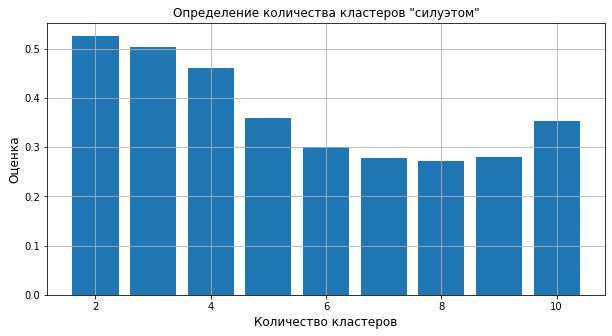

In [30]:
silhouette_score_ac = []

for n_cluster in range(2,11):
    # строим матрицу смежности
    connectivity = kneighbors_graph(X, n_neighbors=2, include_self=False)
    # делаем матрицу смежности симметричной
    connectivity = 0.5 * (connectivity + connectivity.T)
    # создаем объет
    ac = AgglomerativeClustering(n_clusters=n_cluster, linkage='average', connectivity=connectivity)
    ac.fit(X)
    y_pred_ac = ac.labels_.astype(np.int)
    y_pred_ac = ac.fit_predict(X)
    silhouette_score_ac.append(silhouette_score(X=X, labels=y_pred_ac, metric='euclidean'))

plt.figure(figsize=(10,5))
k = [2,3,4,5,6,7,8,9,10]
plt.bar(k, silhouette_score_ac)
plt.title('Определение количества кластеров "силуэтом"', fontsize=12, color='black')
plt.xlabel('Количество кластеров', fontsize=12, color='black')
plt.ylabel('Оценка', fontsize=12, color='black')
plt.grid(True)
plt.show()

Оптимальное количество кластеров **2 шт.** с коэффициентом силуэта - 0,53. Однако разделим данные на 4 кластера с коэффициентом - 0.46.

In [31]:
# создаем объект
ac = AgglomerativeClustering(n_clusters=4, # кол-во кластеров
                             affinity='euclidean', # расстояние : “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, “precomputed”
                             linkage='ward', # способ определения ближайшего соседа: “ward”, “complete”, “average”, “single”
                            )

В расчетах будем использовать матрицу смежности, для которой нужен параметр n_neighbors, то есть число ближайших соседей.
**Матрица смежности** — это матрица, которая соответствует графу, и которая отражает, с какими соседями объект соединен или нет.

In [32]:
# строим матрицу смежности
connectivity = kneighbors_graph(X, n_neighbors=2, include_self=False)

# делаем матрицу смежности симметричной
connectivity = 0.5 * (connectivity + connectivity.T)

In [33]:
# создаем объет
ac = AgglomerativeClustering(n_clusters=4, linkage='average', connectivity=connectivity)

In [34]:
# обучаем модель
ac.fit(X)
y_pred_ac = ac.labels_.astype(np.int)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:502: UserWarning: the number of connected components of the connectivity matrix is 12 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


In [35]:
# добавим столбец с номером кластера
df['Кластер AC'] = y_pred_ac
df.head(3)

,Маршрут,Пенетрация_услуги,Удельная_выручка_на_пассажира,Тип_ВС,Средний_чек_услуги,Количество_проданных_сегментов,ВВЛ/МВЛ,Направленность,Налет,Тип_маршрута,Расстояние,Кластер K-means,Кластер EM,Кластер AC
0,IKT-VKO,0.40268,191.33119,2,487.57926,6337,0,1,5.46666,0,4413.00000,0,0,2
1,AAQ-VKO,0.37797,163.35751,2,421.38962,84801,0,1,2.08626,0,1390.68746,0,3,2
2,AER-TJM,0.36009,172.33264,3,480.23171,9988,0,2,3.44479,1,2548.65625,0,0,2


In [36]:
# список номеров кластера
df['Кластер AC'].unique()

array([2, 0, 3, 1], dtype=int64)

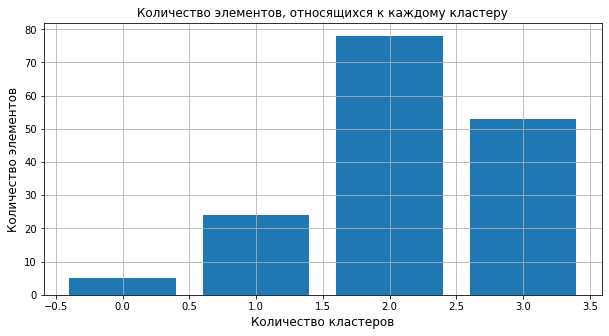

In [37]:
# посмотрим на кол-во элементов в каждом кластере
count_elem_in_cluster('Маршрут','Кластер AC', df, list(df['Кластер AC'].unique()))

In [38]:
# выведем отличия между кластерами
dif_cluster('Кластер AC')

,Номер кластера,Пенетрация,"Расстояние, км.","Средний чек, руб.",Уд. выручка на пас.
0,0,0.14755,762.77404,337.38881,50.30979
1,1,0.16508,796.36168,527.82304,85.45976
2,2,0.27333,2395.96666,482.72199,131.34537
3,3,0.15387,2254.92115,602.30316,92.36360


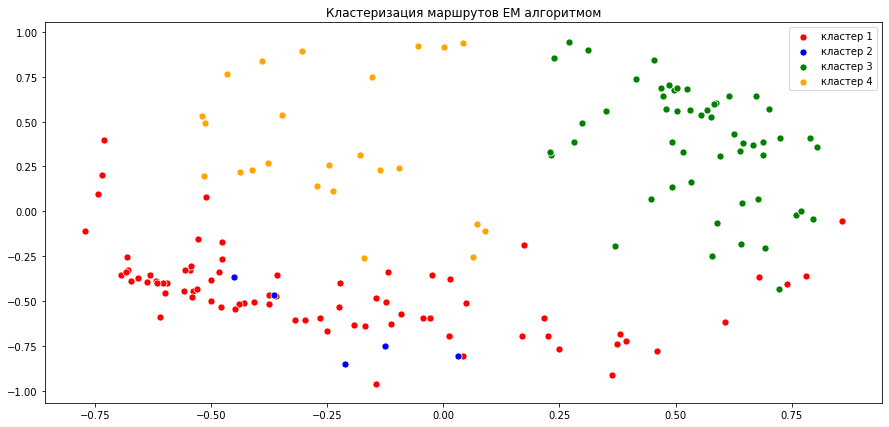

In [39]:
# строим визуализацию

plt.figure(figsize=(15,7))
sns.scatterplot(X[y_pred_ac == 0, 0], X[y_pred_ac == 0, 1], color = 'red', label = 'кластер 1',s=50)
sns.scatterplot(X[y_pred_ac == 1, 0], X[y_pred_ac == 1, 1], color = 'blue', label = 'кластер 2',s=50)
sns.scatterplot(X[y_pred_ac == 2, 0], X[y_pred_ac == 2, 1], color = 'green', label = 'кластер 3',s=50)
sns.scatterplot(X[y_pred_ac == 3, 0], X[y_pred_ac == 3, 1], color = 'orange', label = 'кластер 4',s=50)
plt.title('Кластеризация маршрутов ЕМ алгоритмом', fontsize=12, color='black')
plt.legend()
plt.show()

Еще один способ проведения агломеративной кластеризации через пакет scipy.cluster.hierarchy с построением **дендограммы**.

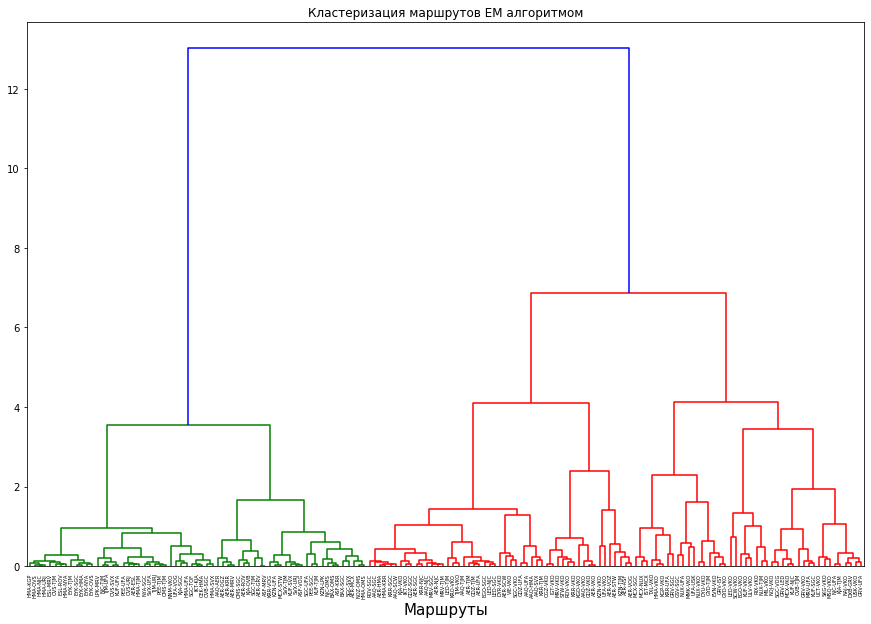

In [40]:
# подготовим данные для построения дендрограммы
# ещё один способ выполнить агломеративную кластеризацию
Z = linkage(X, "ward")

ind = df.set_index('Маршрут')

# строим дендрограмму
plt.figure(figsize=(15,10))
dendrogram(Z, labels=ind.index, leaf_rotation=90.)
plt.title('Кластеризация маршрутов ЕМ алгоритмом', fontsize=12, color='black')
plt.xlabel('Маршруты', fontsize=15, color='black')
plt.show()

Дендограмма тоже делит данные на 2 больших кластера.

**Вывод:** используя агломеративную кластеризацию имеющиеся данные можно разделить на 4 кластера с коэффициентов силуэта, равным 0,46.

### 5.4. DBSCAN

Расшифровывается как **Dense-based spatial clustering of applications with noise**. Это основанная на плотности пространственная кластеризация для приложений с шумами.

Схема действия DBSCAN

* случайно выбираем точку, которую не посещали. Окрестность точки извлекается с использованием расстояния .
* если в этой окрестности точек ≥ minPoints, тогда точка становится первой точкой в новом кластере. Иначе — помечаем точку как шум, она становится посещённой.
* точки из окрестности становятся частью кластера. Для каждой из них изучаем окрестность: если точек в окрестности < minPoints, то помечаем точку как граничную.
* повторяем пункты 2 и 3, пока не определим все точки в кластере.
* повторяем пункты 1–4, пока все точки не станут просмотренными.

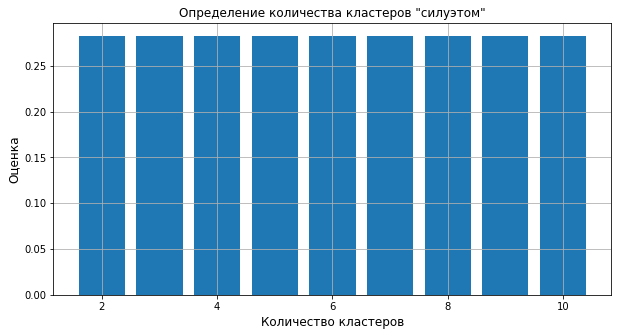

In [41]:
# данные по оценке
silhouette_scores_db = [] 

for n_cluster in range(2, 11):
    dbscan = DBSCAN(eps=0.2, min_samples=5)
    dbscan.fit(X)
    y_pred_db = dbscan.labels_.astype(np.int)
    silhouette_scores_db.append(silhouette_score(X, labels=y_pred_db)) 
    
plt.figure(figsize=(10,5))
k = [2,3,4,5,6,7,8,9,10]
plt.bar(k, silhouette_scores_db)
plt.title('Определение количества кластеров "силуэтом"', fontsize=12, color='black')
plt.xlabel('Количество кластеров', fontsize=12, color='black')
plt.ylabel('Оценка', fontsize=12, color='black')
plt.grid(True)
plt.show()

In [42]:
# создаем объект
dbscan = DBSCAN(eps=0.2, # размер окрестности
                min_samples=5) # минимальное число точек в окрестности

In [43]:
# обучаем модель
dbscan.fit(X)
y_pred_db = dbscan.labels_.astype(np.int)

In [44]:
# добавим столбец с номером кластера
df['Кластер DB'] = y_pred_db
df.head(3)

,Маршрут,Пенетрация_услуги,Удельная_выручка_на_пассажира,Тип_ВС,Средний_чек_услуги,Количество_проданных_сегментов,ВВЛ/МВЛ,Направленность,Налет,Тип_маршрута,Расстояние,Кластер K-means,Кластер EM,Кластер AC,Кластер DB
0,IKT-VKO,0.40268,191.33119,2,487.57926,6337,0,1,5.46666,0,4413.00000,0,0,2,0
1,AAQ-VKO,0.37797,163.35751,2,421.38962,84801,0,1,2.08626,0,1390.68746,0,3,2,-1
2,AER-TJM,0.36009,172.33264,3,480.23171,9988,0,2,3.44479,1,2548.65625,0,0,2,0


In [45]:
# список номеров кластера
df['Кластер DB'].unique()

array([ 0, -1,  1,  2], dtype=int64)

DBSCAN определяет **выбросы**, относя их к кластеру -1. 

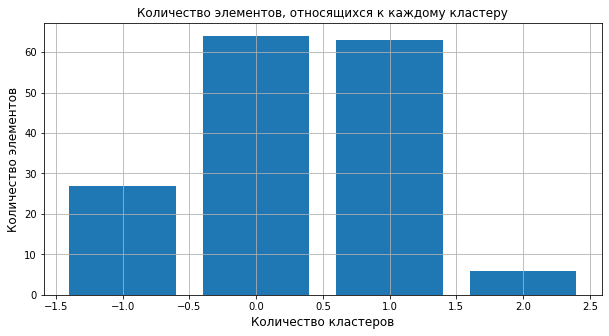

In [46]:
# посмотрим на кол-во элементов в каждом кластере
count_elem_in_cluster('Маршрут','Кластер DB', df, list(df['Кластер DB'].unique()))

In [47]:
# выведем отличия между кластерами
dif_cluster('Кластер DB')

,Номер кластера,Пенетрация,"Расстояние, км.","Средний чек, руб.",Уд. выручка на пас.
0,-1,0.20542,1859.47007,500.54887,99.74441
1,0,0.28912,2725.30880,483.31023,138.92779
2,1,0.13534,646.54848,323.49576,44.28797
3,2,0.17221,1876.75791,588.37453,100.77647


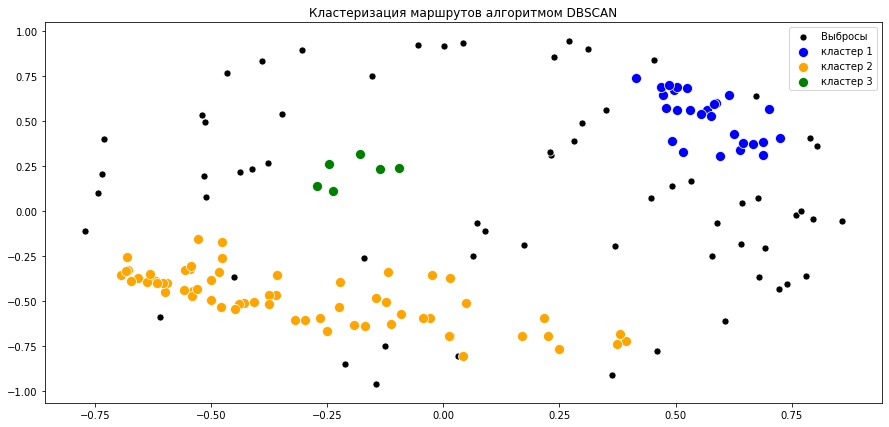

In [48]:
# строим визуализацию

plt.figure(figsize=(15,7))
sns.scatterplot(X[y_pred_db == -1, 0], X[y_pred_db == -1, 1], color = 'black', label = 'Выбросы',s=50)
sns.scatterplot(X[y_pred_db == 0, 0], X[y_pred_db == 0, 1], color = 'blue', label = 'кластер 1',s=100)
sns.scatterplot(X[y_pred_db == 1, 0], X[y_pred_db == 1, 1], color = 'orange', label = 'кластер 2',s=100)
sns.scatterplot(X[y_pred_db == 2, 0], X[y_pred_db == 2, 1], color = 'green', label = 'кластер 3',s=100)

plt.title('Кластеризация маршрутов алгоритмом DBSCAN', fontsize=12, color='black')
plt.legend()
plt.show()

**Вывод:** коэффициент силуэта составляет 0,25, что ниже порогового значения в 0,5. Однако алгоритм DBSCAN лучше кластеризирует имеющиеся данные за счет распознавания выбросов.

Выведем список маршрутов в каждом кластере.

In [49]:
print("Список маршрутов в 1 кластере",list(df[df['Кластер DB'] == 0]['Маршрут']))
print()
print("Список маршрутов в 2 кластере",list(df[df['Кластер DB'] == 1]['Маршрут']))
print()
print("Список маршрутов в 3 кластере",list(df[df['Кластер DB'] == 2]['Маршрут']))
print()
print("Список уникальных маршрутов",list(df[df['Кластер DB'] == -1]['Маршрут']))

Список маршрутов в 1 кластере ['IKT-VKO', 'AER-TJM', 'LED-NJC', 'GDZ-TJM', 'KJA-VKO', 'AAQ-TJM', 'AAQ-NJC', 'EGO-SGC', 'AER-NJC', 'GDZ-SGC', 'AER-SGC', 'LED-SGC', 'KRR-NJC', 'MRV-SGC', 'LED-TJM', 'AAQ-SGC', 'AER-HMA', 'KRR-SGC', 'KRO-VKO', 'HMA-KRR', 'MRV-TJM', 'AAQ-SVX', 'KRR-TJM', 'AER-UFA', 'ROV-SGC', 'TJM-VKO', 'AAQ-SCW']

Список маршрутов в 2 кластере ['AER-KRR', 'AER-MRV', 'AER-OGZ', 'AAQ-AER', 'AER-ROV', 'OMS-SGC', 'KJA-OVB', 'KZN-LPK', 'SGC-TJM', 'AER-GRV', 'ASF-MRV', 'PEE-SGC', 'KUF-TJM', 'BAX-OMS', 'ASF-KRR', 'NJC-OMS', 'BAX-SGC', 'NOZ-OMS', 'KRR-VOG', 'HMA-OMS', 'KZN-UFA', 'MCX-STW', 'AER-MCX', 'SGC-SVX', 'KUF-SVX', 'SVX-TJM', 'LPK-MRV', 'SVX-URJ', 'ASF-VOG', 'NJC-TJM', 'TJM-UFA', 'OVS-SVX', 'UFA-VOG', 'PEE-TJM', 'KJA-SGC', 'OMS-TJM', 'KUF-UFA', 'OVB-SGC', 'NYA-SGC', 'TJM-URJ', 'HMA-UFA', 'IKT-KJA', 'CEK-HMA', 'SVX-UFA', 'HMA-SVX', 'SGC-TOF', 'AER-ESL', 'PEE-UFA', 'HMA-TJM', 'HMA-NJC', 'OVS-TJM', 'ESL-ROV', 'OVS-URJ', 'ESL-MRV', 'HMA-URJ', 'HMA-OVS', 'EYK-TJM', 'EYK-SGC', 'H

**Вывод:** для кластеризации маршрутов лучше всего использовать алгоритм DBSCAN, т.к. он различает выбросы (в нашем случае это специфичные рейсы). Даныне были разбиты алгоритмом на 3 кластера. Маршруты, находящиеся в 1 кластере можно использовать для сравнения друг с другом.